In [7]:
import numpy as np
# Imports NumPy for numerical operations and arrays

import pandas as pd
# Imports pandas for loading and manipulating the CSV dataset

import matplotlib.pyplot as plt
# Imports matplotlib for plotting graphs

from sklearn.model_selection import train_test_split
# Imports a helper to split data into train/test sets (optional but useful)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Imports encoders/scalers to turn categorical text into numbers and normalize numeric features

from sklearn.compose import ColumnTransformer
# Imports a tool to apply different preprocessing to different columns

from sklearn.pipeline import Pipeline
# Imports Pipeline to chain preprocessing + model steps cleanly

from sklearn.cluster import KMeans
# Imports K-means clustering algorithm

from sklearn.mixture import GaussianMixture
# Imports Gaussian Mixture Model (GMM) for density-based clustering (EM algorithm)

from sklearn.decomposition import PCA
# Imports PCA to reduce many features down to 2D for plotting clusters

from sklearn.metrics import silhouette_score
# Imports silhouette score to measure clustering quality (model fit quality)

### df = pd.read_csv("students_ai_usage.csv")
# Loads the CSV file into a pandas DataFrame called df

print(df.head())
# Prints the first 5 rows so you can verify the file loaded correctly

print(df.info())
# Shows column names, non-null counts, and data types

print(df.isna().sum())
# Counts missing values per column to see if cleanup is needed

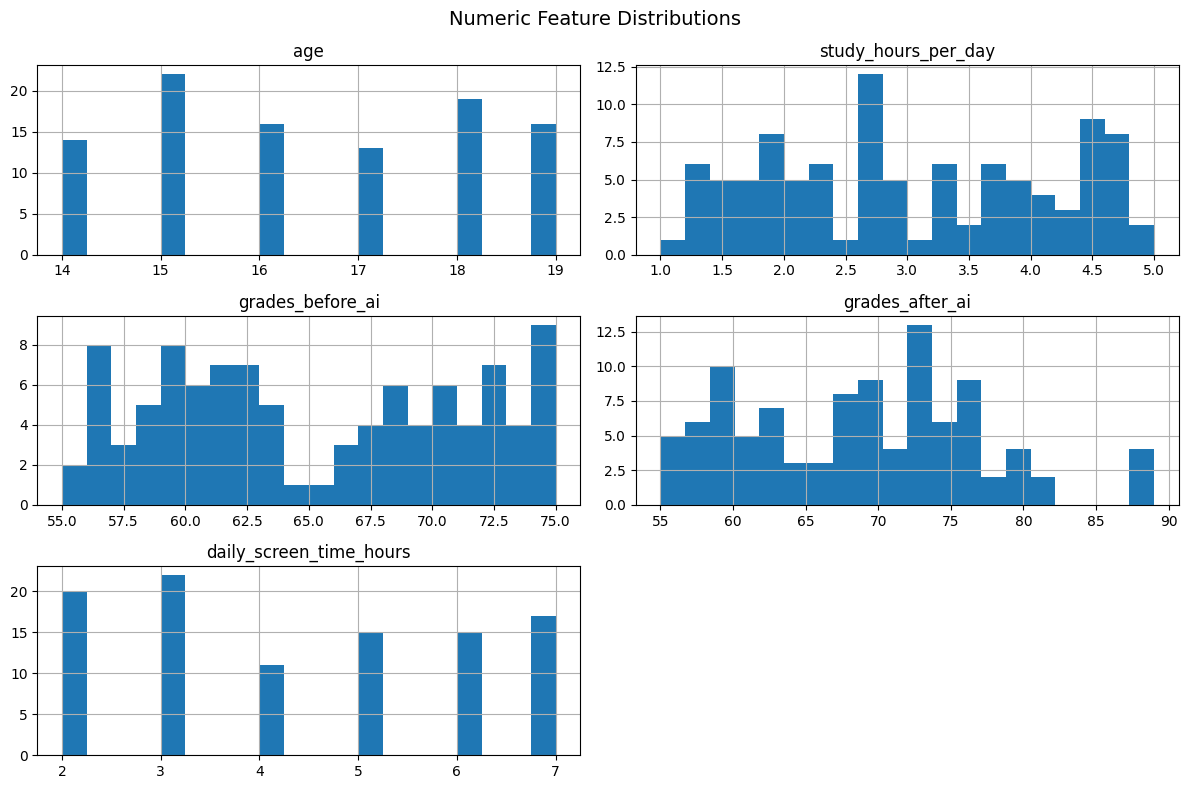

In [8]:
numeric_cols = [
    "age",
    "study_hours_per_day",
    "grades_before_ai",
    "grades_after_ai",
    "daily_screen_time_hours"
]
# Creates a list of numeric columns we want to visualize

df[numeric_cols].hist(bins=20, figsize=(12, 8))
# Draws histograms for each numeric column with 20 bins in a 12x8 figure

plt.suptitle("Numeric Feature Distributions", fontsize=14)
# Adds a title at the top of the multi-plot figure

plt.tight_layout()
# Adjusts spacing to prevent overlap of titles/axes

plt.show()
# Displays the figure

In [9]:
target_like_cols = ["uses_ai"]
# Stores a list of columns that are “target-like” (binary) so we can choose whether to include them

categorical_cols = [
    "education_level",
    "ai_tools_used",
    "purpose_of_ai"
]
# Lists categorical columns that must be converted from text into numbers

all_cols = df.columns.tolist()
# Gets all column names as a list

feature_cols = [c for c in all_cols if c not in []]
# Creates a feature list (we are not removing anything here yet)

X = df.dropna().copy()
# Drops rows with missing values and makes a clean copy for modeling

X_features = X.drop(columns=[])
# Keeps all columns as features (you can remove columns here if you want later)

num_cols = [c for c in numeric_cols if c in X_features.columns]
# Keeps only numeric columns that actually exist in the DataFrame

cat_cols = [c for c in categorical_cols if c in X_features.columns]
# Keeps only categorical columns that actually exist in the DataFrame

bin_cols = ["uses_ai"] if "uses_ai" in X_features.columns else []
# If uses_ai exists, keep it in a separate list (it’s binary)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("bin", "passthrough", bin_cols),
    ]
)
# Builds a preprocessing object:
# - Standardizes numeric columns
# - One-hot encodes categorical columns
# - Passes binary column through unchanged

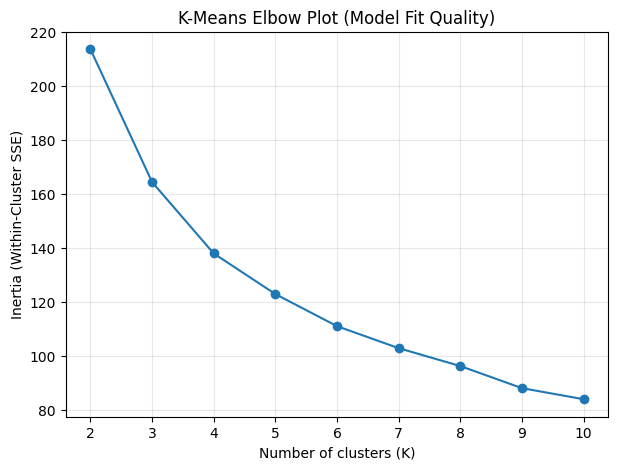

In [10]:
X_features["uses_ai"] = X_features["uses_ai"].astype(str).str.strip()
# Converts uses_ai to string and removes leading/trailing spaces (keeps "Yes"/"No" casing)

X_features["uses_ai"] = X_features["uses_ai"].map({"Yes": 1, "No": 0})
# Maps "Yes" -> 1 and "No" -> 0 so KMeans can use it as a numeric feature

X_features = X_features.dropna(subset=["uses_ai"])
# Drops any rows where uses_ai was not exactly "Yes" or "No" (just in case)

X_proc = preprocess.fit_transform(X_features)
# Applies preprocessing and outputs a fully numeric matrix for clustering

ks = range(2, 11)
# Defines K values from 2 to 10 for testing

inertias = []
# Creates an empty list to store inertia values for each K

for k in ks:
    # Loops over each possible number of clusters
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    # Creates a KMeans model with k clusters (n_init repeats init for stability)
    km.fit(X_proc)
    # Fits the KMeans model to the preprocessed data
    inertias.append(km.inertia_)
    # Stores the inertia (within-cluster sum of squares) for the elbow method

plt.figure(figsize=(7, 5))
# Creates a new figure

plt.plot(list(ks), inertias, marker="o")
# Plots inertia vs K to find the “elbow”

plt.xlabel("Number of clusters (K)")
# Labels x-axis

plt.ylabel("Inertia (Within-Cluster SSE)")
# Labels y-axis

plt.title("K-Means Elbow Plot (Model Fit Quality)")
# Adds title emphasizing fit quality

plt.grid(True, alpha=0.3)
# Adds a faint grid

plt.show()
# Displays the elbow plot

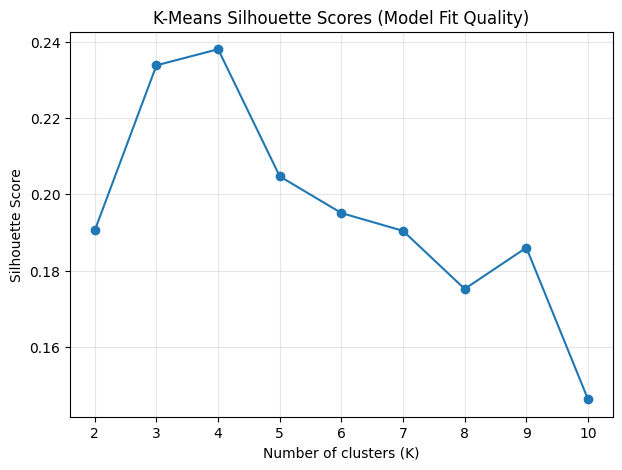

In [11]:
sil_scores = []
# Creates an empty list for silhouette scores

for k in ks:
    # Loops over each K
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    # Creates the KMeans model
    labels = km.fit_predict(X_proc)
    # Fits model and gets cluster labels for each point
    sil = silhouette_score(X_proc, labels)
    # Computes silhouette score (higher is better)
    sil_scores.append(sil)
    # Stores the score for plotting

plt.figure(figsize=(7, 5))
# Creates a new figure

plt.plot(list(ks), sil_scores, marker="o")
# Plots silhouette vs K to choose the best K

plt.xlabel("Number of clusters (K)")
# Labels x-axis

plt.ylabel("Silhouette Score")
# Labels y-axis

plt.title("K-Means Silhouette Scores (Model Fit Quality)")
# Adds title emphasizing fit quality

plt.grid(True, alpha=0.3)
# Adds a faint grid

plt.show()
# Displays the silhouette plot

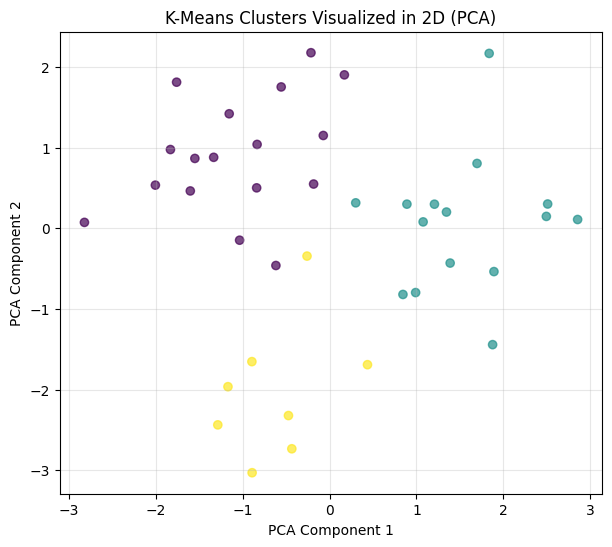

In [12]:
best_k = 3
# Sets the number of clusters you decided to use (change based on elbow/silhouette)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
# Creates the final KMeans model using best_k

labels_km = kmeans.fit_predict(X_proc)
# Fits KMeans and returns the cluster label for each student

pca = PCA(n_components=2, random_state=42)
# Creates PCA reducer to 2D for plotting

X_2d = pca.fit_transform(X_proc)
# Reduces your high-dimensional data to 2D coordinates

plt.figure(figsize=(7, 6))
# Creates a new figure window

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_km, alpha=0.7)
# Plots points in PCA space colored by KMeans cluster label

plt.xlabel("PCA Component 1")
# Labels x-axis

plt.ylabel("PCA Component 2")
# Labels y-axis

plt.title("K-Means Clusters Visualized in 2D (PCA)")
# Adds plot title

plt.grid(True, alpha=0.3)
# Adds faint grid

plt.show()
# Displays the cluster visualization

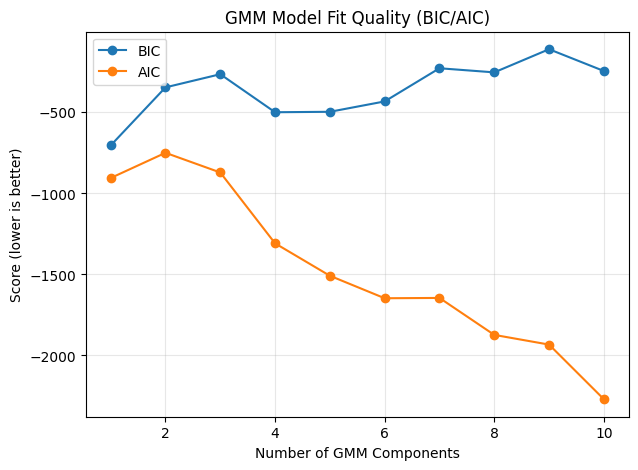

In [13]:
components = range(1, 11)
# Tests number of mixture components from 1 to 10

bics = []
# Stores Bayesian Information Criterion values

aics = []
# Stores Akaike Information Criterion values

for c in components:
    # Loops over each component count
    gmm = GaussianMixture(n_components=c, random_state=42, covariance_type="full")
    # Creates a GMM with c Gaussian components
    gmm.fit(X_proc)
    # Fits the GMM using Expectation-Maximization (EM)
    bics.append(gmm.bic(X_proc))
    # Computes BIC for this model (lower is better)
    aics.append(gmm.aic(X_proc))
    # Computes AIC for this model (lower is better)

plt.figure(figsize=(7, 5))
# Creates a new figure

plt.plot(list(components), bics, marker="o", label="BIC")
# Plots BIC values across component counts

plt.plot(list(components), aics, marker="o", label="AIC")
# Plots AIC values across component counts

plt.xlabel("Number of GMM Components")
# Labels x-axis

plt.ylabel("Score (lower is better)")
# Labels y-axis

plt.title("GMM Model Fit Quality (BIC/AIC)")
# Adds title emphasizing model fit quality

plt.legend()
# Shows legend for BIC vs AIC

plt.grid(True, alpha=0.3)
# Adds faint grid

plt.show()
# Displays the plot

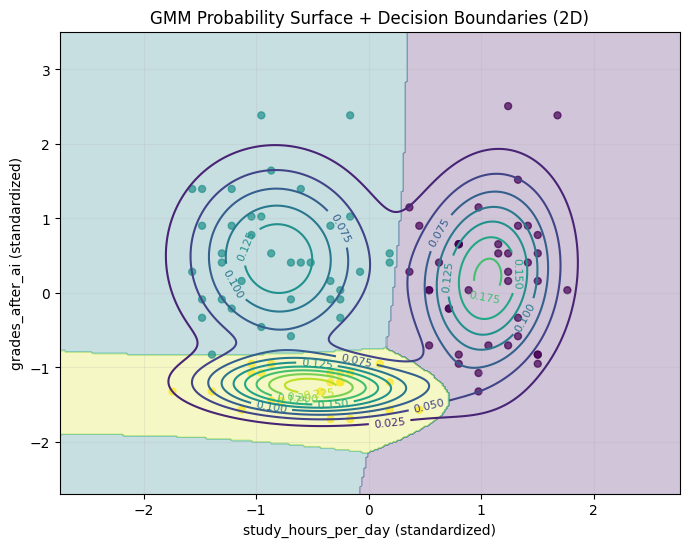

In [14]:
feat_x = "study_hours_per_day"
# Chooses the first feature for 2D surface plotting

feat_y = "grades_after_ai"
# Chooses the second feature for 2D surface plotting

D2 = df[[feat_x, feat_y]].dropna().copy()
# Extracts only those two columns and drops missing rows

scaler_2d = StandardScaler()
# Creates a scaler so both axes are comparable

Z = scaler_2d.fit_transform(D2)
# Standardizes the 2D data for stable GMM fitting

gmm2 = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
# Creates a 2D GMM with 3 components (tune based on BIC/AIC)

gmm2.fit(Z)
# Fits the 2D GMM using EM

labels_gmm2 = gmm2.predict(Z)
# Predicts the most likely Gaussian component for each point

x_min, x_max = Z[:, 0].min() - 1, Z[:, 0].max() + 1
# Sets grid limits for x dimension (standardized space)

y_min, y_max = Z[:, 1].min() - 1, Z[:, 1].max() + 1
# Sets grid limits for y dimension (standardized space)

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
# Creates a dense 2D grid to evaluate probabilities everywhere

grid = np.c_[xx.ravel(), yy.ravel()]
# Flattens the grid into a list of (x,y) points for model scoring

logprob = gmm2.score_samples(grid)
# Computes log probability density for each grid point under the GMM

prob = np.exp(logprob).reshape(xx.shape)
# Converts log density to density and reshapes back to grid shape

pred = gmm2.predict(grid).reshape(xx.shape)
# Predicts which component “wins” at each grid location (decision regions)

plt.figure(figsize=(8, 6))
# Creates the figure window

plt.contourf(xx, yy, pred, alpha=0.25)
# Draws filled regions showing decision boundaries between components

cs = plt.contour(xx, yy, prob, levels=10)
# Draws contour lines of probability density (probability surface)

plt.clabel(cs, inline=True, fontsize=8)
# Adds labels to the contour lines

plt.scatter(Z[:, 0], Z[:, 1], c=labels_gmm2, s=25, alpha=0.7)
# Plots the actual data points, colored by GMM component assignment

plt.xlabel(f"{feat_x} (standardized)")
# Labels x-axis in standardized units

plt.ylabel(f"{feat_y} (standardized)")
# Labels y-axis in standardized units

plt.title("GMM Probability Surface + Decision Boundaries (2D)")
# Adds title describing what teacher asked for

plt.grid(True, alpha=0.2)
# Adds faint grid

plt.show()
# Displays the surface + boundary plot

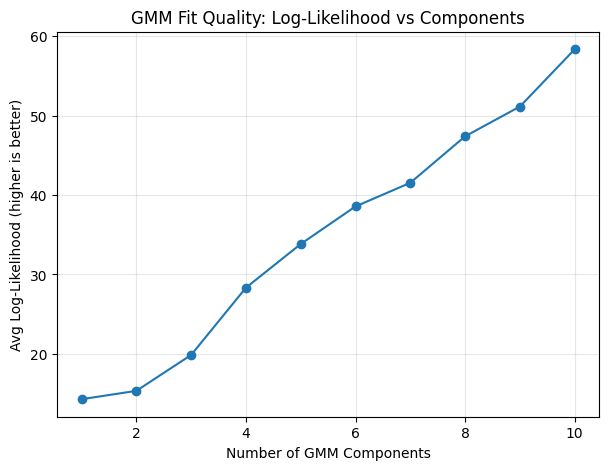

In [15]:
lls = []
# Creates a list to store average log-likelihood values

for c in components:
    # Loops over component counts 1..10
    gmm = GaussianMixture(n_components=c, random_state=42, covariance_type="full")
    # Creates a GMM model
    gmm.fit(X_proc)
    # Fits the model using EM
    lls.append(gmm.score(X_proc))
    # Stores the average log-likelihood per sample (higher is better)

plt.figure(figsize=(7, 5))
# Creates a new figure

plt.plot(list(components), lls, marker="o")
# Plots log-likelihood vs number of components

plt.xlabel("Number of GMM Components")
# Labels x-axis

plt.ylabel("Avg Log-Likelihood (higher is better)")
# Labels y-axis

plt.title("GMM Fit Quality: Log-Likelihood vs Components")
# Adds title emphasizing model fit quality

plt.grid(True, alpha=0.3)
# Adds faint grid

plt.show()
# Displays the plot